In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from deap import algorithms, base, creator, tools

## Loading data

In [2]:
returns = pd.read_csv("../data/weekly_returns.csv",index_col="Date")
ibov = pd.read_csv("../data/weekly_ibov.csv",index_col="Date")
volatilities = pd.read_csv("../data/volatility_garch_1_1_7.csv",index_col="Date")

returns.index = pd.to_datetime(returns.index)
ibov.index = pd.to_datetime(ibov.index)
volatilities.index = pd.to_datetime(volatilities.index)

The function below is responsible for getting the portifolio return based on each asset return and the weights given for each asset.

*Parameters:*
 - weights: array with each element being the weight assinged for each asset.
 - asset_returns: array with each element being the asset return. 

*Disclaimer:*
 - Each asset expected return may be obtained with different techniques. In this first version, the expected return is simply the last observed return. In other words, $\hat{y}_t=y_{t-1}$ 
 - Asset returns were obtained with the log-return of the asset Adjusted Closed Price.

In [3]:
def portifolio_return(weights, asset_returns):
    
    '''
    First version -> the expected return from each asset is exactly the last return, which is inspired on Random Walk
    Weights will be othe GA individual
    '''
    
    port_ret = np.dot(weights,asset_returns)
    
    return port_ret

The function below is responsible for getting the portifolio volatility based on each asset volatility and the weights given for each asset.

*Parameters:*
 - weights: array with each element being the weight assinged for each asset.
 - asset_volatilities: array with each element being the asset volatility predicted by a GARCH Model. 

*Disclaimer:*
 - In the current version, volatilities are being estimated through historical variance and covariance

In [4]:
def covariance_matrix_from_garch(asset_volatilities):
    
    dim = len(asset_volatilities)
    cov_matrix = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            if i == j:
                cov_matrix[i,j] = asset_volatilities[i]
            else:
                cov = asset_volatilities[i]**2 + asset_volatilities[j]**2 + 2*asset_volatilities[i]*asset_volatilities[j]
                cov_matrix[i,j] = cov
                cov_matrix[j,i] = cov
    
    return cov_matrix


def portifolio_volatility(weights,asset_volatilities):
    
    cov_matrix = covariance_matrix_from_garch(asset_volatilities)
    
    weights_np = np.array(weights)
    
    port_vol = np.sqrt(np.dot(weights_np.T,np.dot(cov_matrix,weights_np)))
    
    return port_vol

In [5]:
def portifolio_volatility_naive(weights, returns):
    
    cov_matrix = returns.cov()
    weights_np = np.array(weights)
    
    port_vol = np.sqrt(np.dot(weights_np.T,np.dot(cov_matrix,weights_np)))
    
    return port_vol

In [6]:
weights = np.ones(len(returns.iloc[0,:]))/len(returns.iloc[0,:])


portifolio_return(asset_returns=returns.iloc[0,:],
                  weights=weights)



0.023543951421836032

In [7]:
portifolio_volatility(weights = weights,
                      asset_volatilities = volatilities.iloc[15,:])

0.0767152776321146

## GA Optimization

Por enquanto eu apenas estou maximizando retorno, sem olhar a volatilidade

In [8]:
#First, only maximize portfolio return
def objective_function(individual):

    return portifolio_return(individual,asset_returns)/portifolio_volatility(individual,asset_volatilities)  
    

In [9]:
def feasible(individual):
    cond1 = 1-sum(individual)>0 
    cond2 = 1-sum(individual)<10e-7
    
    all_positive = True
    for gene in individual:
        if gene < 0:
            all_positive = False
            
    #port_vol = portifolio_volatility(individual,asset_volatilities)
    #cond_vol = port_vol <= 0.15
    return cond1 and cond2 and all_positive  #and cond_vol

In [10]:
def distance(individual):
    
    return abs(sum(individual)-1)

### GA setup

In [11]:
creator.create('FitnessMax',base.Fitness,weights=(1.0,)) 
creator.create('Individual',list,fitness=creator.FitnessMax) 

In [12]:
toolbox = base.Toolbox()

toolbox.register("attr_weight", random.uniform, 0, 1/19)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_weight, n=19)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  

In [13]:
toolbox.register("evaluate", objective_function)     
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 0, distance))

In [14]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=1, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [15]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('avg',np.mean)
stats.register('std',np.std)
stats.register('max',np.max)
stats.register('min',np.min)

In [16]:
train_returns = returns[returns.index.year < 2021]
test_returns =  returns[returns.index.year == 2021]

train_volatilities = volatilities[volatilities.index.year < 2021]
test_volatilities = volatilities[volatilities.index.year == 2021]

## Hyperparameter Search on training dataset

In [17]:
hyperparameters = {"population":[50,100],
                   "cxpb":[0.3,0.5],
                    "mutpb":[0.05,0.1],
                    "ngen":[20,50]}

keys, values = zip(*hyperparameters.items())
hyperparameters_permutations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print("Number of models to do compared = %d"%len(hyperparameters_permutations))

Number of models to do compared = 16


In [18]:
best_cummulative_return = 0
best_hyperparametrs = {}

comparing_hyperparameters = []

c=0
for parameters in hyperparameters_permutations:
    optimal_returns = {}
    best_individuals = {}
    
    hof = tools.HallOfFame(1)
    pop = toolbox.population(n=parameters["population"]) 
    cxpb = parameters["cxpb"]
    mutpb = parameters["mutpb"]
    ngen = parameters["ngen"]
    
    for idx,row in train_returns.iterrows():
        asset_returns = row
        asset_volatilities = train_volatilities.loc[idx,:]
        if asset_volatilities.isna().sum() == 0:
            pop,log = algorithms.eaSimple(population=pop, toolbox=toolbox, cxpb=cxpb, mutpb=mutpb,
                                    ngen=ngen, stats=stats, halloffame=hof,verbose=False)
            

            best_individuals[idx] = hof[0]
            optimal_returns[idx] = objective_function(hof[0])
    
    optimal_returns = pd.DataFrame(index=optimal_returns.keys(),data=optimal_returns.values())
    portifolio_cummulative_return = optimal_returns.cumsum()
    
    parameters["cummulative return"] = portifolio_cummulative_return
    comparing_hyperparameters.append(parameters)
    
    
    if portifolio_cummulative_return.values[-1][0] > best_cummulative_return:
        best_hyperparametrs = parameters
    
    # if c == 10:
    #     break
    # c+=1

print("Best Hyperparameters are:")
print(best_hyperparametrs)

C:\Users\matno\AppData\Local\Temp\ipykernel_6372\4074511895.py:23: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(weights_np.T,np.dot(cov_matrix,weights_np)))
C:\Users\matno\AppData\Local\Temp\ipykernel_6372\4074511895.py:23: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(weights_np.T,np.dot(cov_matrix,weights_np)))
C:\Users\matno\AppData\Local\Temp\ipykernel_6372\4074511895.py:23: RuntimeWarning: invalid value encountered in sqrt
  port_vol = np.sqrt(np.dot(weights_np.T,np.dot(cov_matrix,weights_np)))


Best Hyperparameters are:
{'population': 100, 'cxpb': 0.5, 'mutpb': 0.1, 'ngen': 20, 'cummulative return':                     0
2010-02-22  -0.165123
2010-03-01  -0.076719
2010-03-08  -0.018733
2010-03-15  -0.426419
2010-03-22  -0.532059
...               ...
2020-11-30  10.555181
2020-12-07  10.715480
2020-12-14  10.734405
2020-12-21  10.741583
2020-12-28  10.915290

[567 rows x 1 columns]}


## Best Hyperparameters result on training data

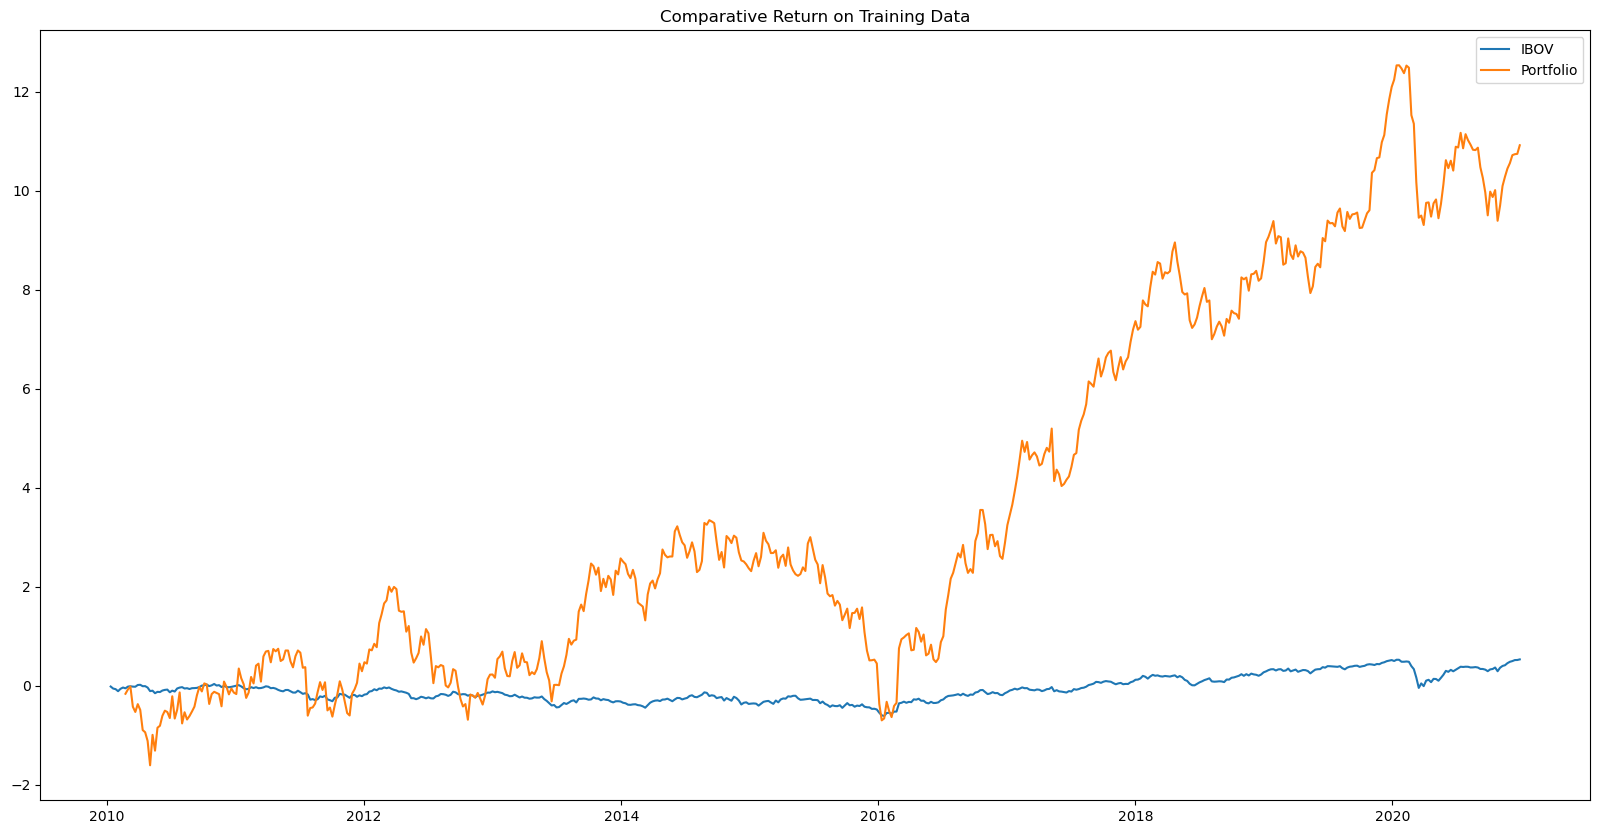

In [19]:
ibov_cummulative_return = ibov.cumsum()

train_ibov = ibov_cummulative_return[ibov_cummulative_return.index.year<2021]
test_ibov = ibov_cummulative_return[ibov_cummulative_return.index.year==2021]

plt.figure(figsize=(20,10))
plt.plot(train_ibov,label="IBOV")
plt.plot(best_hyperparametrs["cummulative return"],label="Portfolio")
plt.title("Comparative Return on Training Data")
plt.legend()
plt.show()

## Best Hyperparameters result on test data

In [20]:
best_individuals = {}
optimal_returns = {}

hof = tools.HallOfFame(1)
pop = toolbox.population(n=best_hyperparametrs["population"]) 

cxpb = best_hyperparametrs["cxpb"]
mutpb = best_hyperparametrs["mutpb"]
ngen = best_hyperparametrs["ngen"]

for idx,row in test_returns.iterrows():
    asset_returns = row
    asset_volatilities = test_volatilities.loc[idx,:]
    if asset_volatilities.isna().sum() == 0:
        pop,log = algorithms.eaSimple(population=pop, toolbox=toolbox, cxpb=cxpb, mutpb=mutpb,
                                ngen=ngen, stats=stats, halloffame=hof,verbose=False)
        

        best_individuals[idx] = hof[0]
        optimal_returns[idx] = objective_function(hof[0])
        
optimal_returns = pd.DataFrame(index=optimal_returns.keys(),data=optimal_returns.values())
optimal_returns.rename(columns={0:"Return"},inplace=True)    

portifolio_cummulative_return = optimal_returns.cumsum()
    

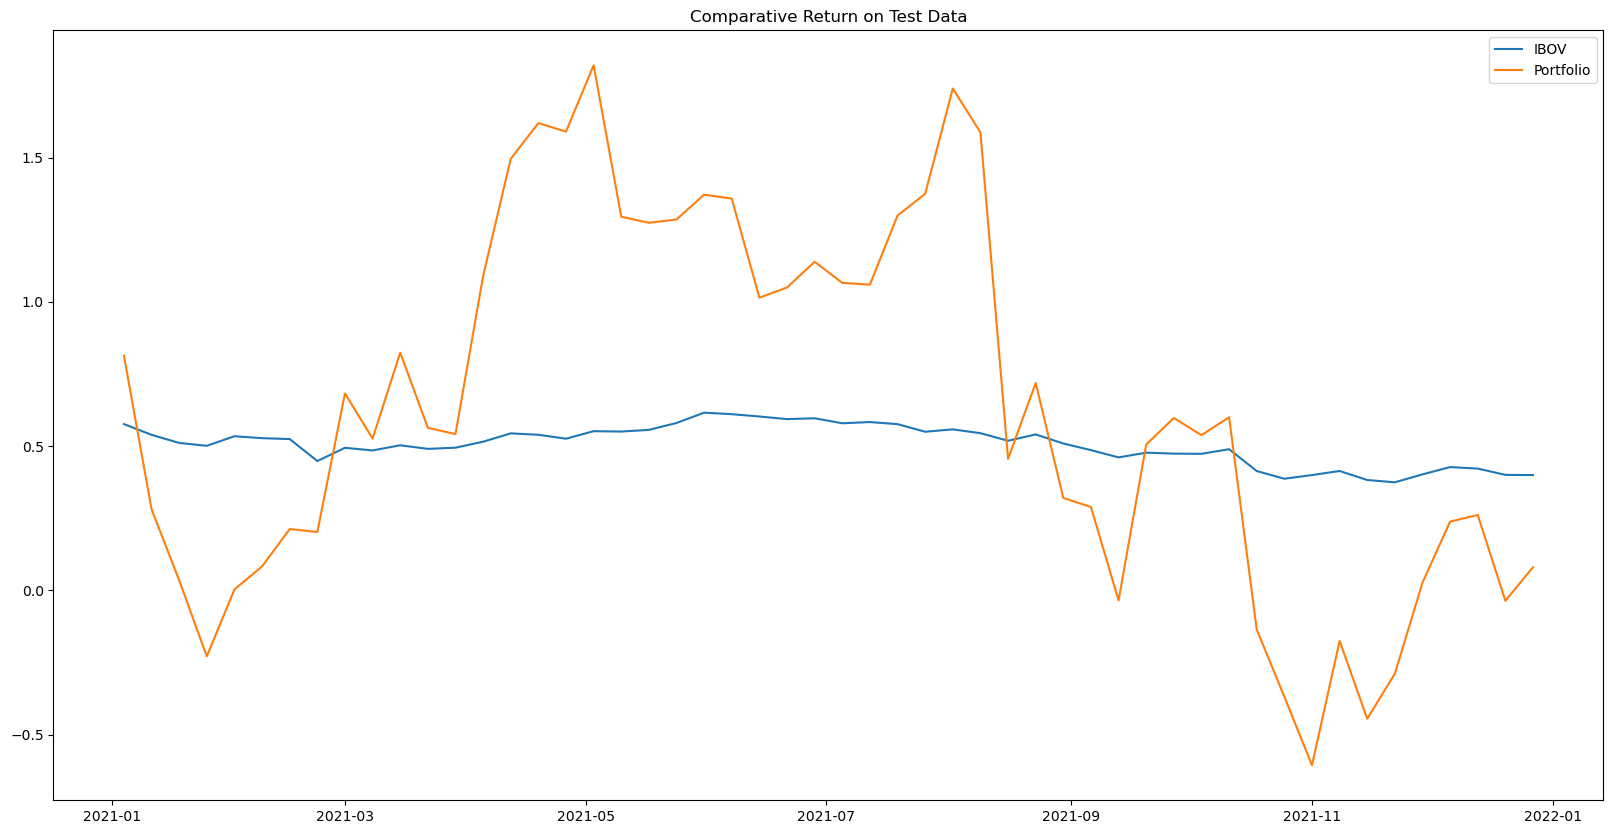

In [21]:
plt.figure(figsize=(20,10))
plt.plot(test_ibov,label="IBOV")
plt.plot(portifolio_cummulative_return,label="Portfolio")
plt.title("Comparative Return on Test Data")
plt.legend()
plt.show()